In [1]:
import sys
import os
import subprocess
import pandas as pd
import numpy as np
import tempfile
import yaml

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

import os

from datetime import date
print(date.today())
# conda install mkl-service mkl
import mkl
nCPU= 20
N=4


2025-12-09


In [9]:
# 准备结果目录和流程所需config文件
# level 1
workdir = '/mnt/disk7t/xwj/axolotl_rev/'

# level 1
workdir = '/mnt/disk7t/xwj/axolotl_rev/'
datadir = '/mnt/disk7t/xwj/axolotl_rev/ly_111/'
output_path = f'{workdir}/result/dataset_ly111'


use = 'ly111'
tissues = pd.read_csv(f'{datadir}/tissues_{use}.tsv', sep='\t', index_col=0)
phase =''
outlier_sample_col = 'Sample'
outlier_gene_col = 'Gene'

samples_path = f'{output_path}/samples'
task_config_path = f'{output_path}/task_config'
task_output_path = f'{output_path}/task_output'
metric_output_path = f'{output_path}/metric'

tissues1 = tissues.copy()
tissues1['OUTLIER_FILE'] = f'{datadir}/outlier_ly111_filtered_by_cts_444.tsv'
tissues = pd.concat([tissues, tissues1], axis=0)
tissues
tissues.head()

,TISSUE_ID,TISSUE_NAME,N_SAMPLE,N_GENE,CTS_FILE,OUTLIER_FILE
0,B,blood,111,11310,/mnt/disk7t/xwj/axolotl_rev/ly_111//cts_B_s111...,/mnt/disk7t/xwj/axolotl_rev/ly_111//outlier_B_...
0,B,blood,111,11310,/mnt/disk7t/xwj/axolotl_rev/ly_111//cts_B_s111...,/mnt/disk7t/xwj/axolotl_rev/ly_111//outlier_ly...


In [85]:

# 定义排序逻辑
score_order = {
    'anomaly_score': False,
    'delta_count': True,
    'divergence_score': True,
    'pValue': True,
    'padjust': True,
    'zScore': True,
}

abl_scores = ['anomaly_score', 'delta_count', 'divergence_score']
outrider_scores = [ 'padjust']
baselines = [ f'{m}_{score}' for m in [ 'ABEILLE', 'OUTRIDER'] for score in (outrider_scores if m=='OUTRIDER' else abl_scores) ] + ['OUTSINGLE']

mymethods = [ f'{f}{m}' for f in ['f0.1', ] 
             for m in ['L20',] ]
methods = mymethods + baselines
# methods = ['OUTRIDER_padjust',
#  'ABEILLE_anomaly_score',
#  'ABEILLE_delta_count',
#  'ABEILLE_divergence_score',
#  'OUTSINGLE',
#  'f0.1L20',
# ]
num = 49
print(num, phase, methods)

49  ['f0.1L20', 'ABEILLE_anomaly_score', 'ABEILLE_delta_count', 'ABEILLE_divergence_score', 'OUTRIDER_padjust', 'OUTSINGLE']


In [4]:
## topn recall

def pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier):
    """
    计算ABEILLE方法单个打分方式的AUPRC
    参数:
        res_data: 包含预测结果的DataFrame
        score_col: 用于排序的打分列名
        df_outlier: 包含真实异常的DataFrame
    """
    # 按predict和score排序
    ascend = score_order[ score_col ]
    sorted_data = res_data.pivot_table(columns=sample_col, index=gene_col, values=score_col).rank(ascending=ascend, method='first')
    outlier_rank = [ sorted_data.loc[g,s] for g,s in zip(df_outlier['Gene'], df_outlier['Sample'])]
    new_df_outlier = df_outlier.copy() # must make a copy
    new_df_outlier['rank'] = outlier_rank
    return new_df_outlier

def sort_score_outlier_rank(res_data, df_outlier, ascend=True):
    sorted_data = res_data.rank(ascending=ascend, method='first')
    outlier_rank = [ sorted_data.loc[g,s] for g,s in zip(df_outlier['Gene'], df_outlier['Sample'])]
    new_df_outlier = df_outlier.copy() # must make a copy
    new_df_outlier['rank'] = outlier_rank
    return new_df_outlier


In [10]:
%%time


from tqdm import tqdm
# 为兼容以后的子集抽样，需要定义保存不同抽样方案的outlier
dict_outlier_setting = dict()
dict_outlier_setting['all'] = {} 


## 分析一个完整dataset，不带子集抽样
for i, row in tissues.iterrows():
    # --> level 1. one tissue
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    dict_res = dict()
    dict_auprc = dict()
    dict_curve = dict()
    
    # --> level 2. (tissue, task) one tissue have many tasks
    prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    
    # 读入任务
    task_config = pd.read_csv(f'{task_config_path}/{prefix}.config', sep='\t')
    samples = pd.read_csv(f'{samples_path}/{prefix}.txt', sep='\t',index_col='task')
    # all outlier
    # outliers_used = pd.read_csv(f'{samples_path}/{prefix}_outliers.txt', sep='\t',index_col=0)
    # valid split
    outliers_used = pd.read_csv(outlierfile.replace('.tsv', f'{phase}.tsv'), sep='\t',index_col=0)
    print(prefix, samples.shape, outliers_used.shape)

    if 'Sample' in outliers_used.columns:
        df_outlier = outliers_used
    else:
        outlier_sample_col = 'SAMPLE_ID'
        outlier_gene_col = 'Gene'
        df_outlier = outliers_used.rename(columns={outlier_sample_col:'Sample', outlier_gene_col:'Gene'})
    
    for m in methods:
        # ==> level 3. (tissue, task, method)
        dict_res = dict()
        dict_auprc = dict()
        dict_curve = dict()
        
        for j,row in task_config.iterrows():
            # ==> level 4. (tissue, task, method)
            if m.startswith('ABEILLE'):
                method, score_col = m.split('_',1)
                print(method, score_col)
                res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                res_data.index = [(s,g) for s,g in zip(res_data['Sample'], res_data['Transcript'])]
                class_col = 'predict'
                gene_col = 'Transcript'
                sample_col = 'Sample'
                dict_curve[j] = pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier)
                                                
            elif m.startswith('OUTRIDER'):
                method, score_col = m.split('_',1)
                print(method, score_col)
                res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                res_data.index = [(s,g) for s,g in zip(res_data['sampleID'], res_data['geneID'])]
                class_col = 'aberrant'
                gene_col = 'geneID'
                sample_col = 'sampleID'
                dict_curve[j] = pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier)

            elif m == 'OUTSINGLE':
                print(m)
                df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                dict_curve[j] = sort_score_outlier_rank(df_pred, df_outlier)

            else: # my method
                print(m)
                df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                dict_curve[j] = sort_score_outlier_rank(df_pred, df_outlier)


        # m is done,
        file = f'{metric_output_path}/{prefix}_{m}_rank{phase}{os.path.basename(outlierfile)}.pkl' # one tissue One method   
        outputdata = [ t, tn, i, dict_curve ]
        
        import pickle
        with open(file, 'wb') as f: 
            pickle.dump( outputdata,  f )


t00_B_s111_g11310 (1, 111) (52, 36)
OUTRIDER padjust


ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_score
OUTSINGLE
f0.1L20
t00_B_s111_g11310 (1, 111) (444, 9)
OUTRIDER padjust
ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_score
OUTSINGLE
f0.1L20
CPU times: user 25.1 s, sys: 1.3 s, total: 26.4 s
Wall time: 26.4 s


blood f0.1L20
blood ABEILLE_anomaly_score
blood ABEILLE_delta_count
blood ABEILLE_divergence_score
blood OUTRIDER_padjust
blood OUTSINGLE
blood f0.1L20
blood ABEILLE_anomaly_score
blood ABEILLE_delta_count
blood ABEILLE_divergence_score
blood OUTRIDER_padjust
blood OUTSINGLE


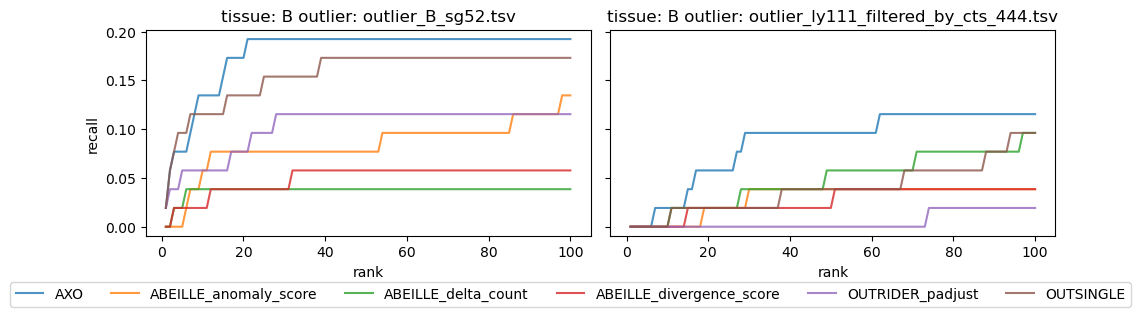

In [86]:
draw_methods = methods
plt.style.use('default')
fig, axes = plt.subplots( 1, len(tissues), figsize=(5*len(tissues), 3), sharey=True)
# pd.DataFrame(index=tissues.index, columns=draw_methods)

ax_i = 0
for i, row in tissues.iterrows():
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    k = 'all'
    dict_curve[k],dict_auprc[k] = dict(),dict()
    if k == 'all':
        prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
        
    for m in draw_methods:
        
        file = f'{metric_output_path}/{prefix}_{m}_rank{phase}{os.path.basename(outlierfile)}.pkl' # one tissue One method
        with open(file,'rb') as f:
            data_load = pickle.load(f)
            print(tn, m)
        _t, _tn, _i, dict_curve[k][m] = data_load[0], data_load[1], data_load[2], data_load[3]
        
    # print(t, tn, i,file)

    required_sets = 1
    max_bin = 100
    bins = list(range(0, max_bin + 1)) + [20000]
    nice_names = list(range(1,max_bin + 1))+[20000]#[ f'{x}%' for x in bins[:-1]]
    
    draw = \
    pd.concat( [ 
            pd.concat( [ (dict_curve[k][m][j]['rank'].value_counts(bins= bins, sort=False)) for j in range(required_sets)], axis=0, keys=range(required_sets))
        for m in draw_methods ], axis=0, keys=draw_methods, names=['method']).rename(index={ 'f0.1L20':'AXO'}).reset_index()

    # sns.lineplot(data=draw, x="recall", y="precision", hue="level_0", palette='tab10', alpha=0.8, ax= axes[i])
    # axes[i].set_title(f'{title}(n={ns})')
    # auprc.loc[i,:] = [ dict_auprc['all'][m][0] for m in draw_methods ]

    draw['rank'] = nice_names * len(draw_methods)
    draw = draw.query('rank < 10000')
    draw['recall'] = draw.groupby('method')['count'].cumsum()/len(df_outlier)

    sns.lineplot(data=draw, x='rank', y="recall", hue="method", palette='tab10', alpha=0.8, ax=axes[ax_i])
    axes[ax_i].set_title(f'tissue: {t} outlier: {os.path.basename(outlierfile)}')
        # 1. 去掉子图自己的图例
    axes[ax_i].get_legend().remove()
    ax_i += 1
# 2. 用最后一根轴的“handles/labels”生成 Figure 级图例
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
        loc='center',           # 居中
        bbox_to_anchor=(0.5, 0),  # 放在底部（微调 0.02）
        ncol=len(labels),       # 横向排列
        frameon=True)
plt.tight_layout()
plt.savefig(f'{workdir}/result/figure/ly111_topn_recall.pdf',dpi=200,bbox_inches='tight' )

In [90]:
## 分析一个完整dataset，不带子集抽样
for i, row in tissues.head(1).iterrows():
    # --> level 1. one tissue
    t  = row.TISSUE_ID
    tn = row.TISSUE_NAME
    ns = row.N_SAMPLE
    ng = row.N_GENE
    ctsfile = row.CTS_FILE
    outlierfile = row.OUTLIER_FILE
    
    dict_rank = dict()
    dict_score = dict()
    
    # --> level 2. (tissue, task) one tissue have many tasks
    prefix = f't{i:02d}_{t}_s{ns}_g{ng}' # id, number of samples, number of genes.
    
    # 读入任务
    task_config = pd.read_csv(f'{task_config_path}/{prefix}.config', sep='\t')
    samples = pd.read_csv(f'{samples_path}/{prefix}.txt', sep='\t',index_col='task')
    # all outlier
    # outliers_used = pd.read_csv(f'{samples_path}/{prefix}_outliers.txt', sep='\t',index_col=0)
    # valid split
    outliers_used = pd.read_csv(outlierfile.replace('.tsv', f'{phase}.tsv'), sep='\t',index_col=0)
    print(prefix, samples.shape, outliers_used.shape)

    if 'Sample' in outliers_used.columns:
        df_outlier = outliers_used
    else:
        outlier_sample_col = 'SAMPLE_ID'
        outlier_gene_col = 'Gene'
        df_outlier = outliers_used.rename(columns={outlier_sample_col:'Sample', outlier_gene_col:'Gene'})
    
    for m in methods:
        # ==> level 3. (tissue, task, method)
        dict_res = dict()
        dict_auprc = dict()
        dict_curve = dict()
        
        for j,row in task_config.iterrows():
            # ==> level 4. (tissue, task, method)
            if m.startswith('ABEILLE'):
                method, score_col = m.split('_',1)
                print(method, score_col)
                
                res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                res_data.index = [(s,g) for s,g in zip(res_data['Sample'], res_data['Transcript'])]
                class_col = 'predict'
                gene_col = 'Transcript'
                sample_col = 'Sample'
                ab_new = res_data.pivot_table(values=score_col, index=gene_col, columns=sample_col).fillna(0)
                dict_score[m] = ab_new.transform(lambda x: (x-x.min())/(x.max()-x.min()), axis=1).fillna(0)
                dict_rank[m] = ab_new.rank(ascending=False)
                                                
            elif m.startswith('OUTRIDER'):
                method, score_col = m.split('_',1)
                print(method, score_col)
                
                res_data = pd.read_csv(f"{row[method]}_raw.gz", sep='\t',index_col=0)
                res_data.index = [(s,g) for s,g in zip(res_data['sampleID'], res_data['geneID'])]
                
                class_col = 'aberrant'
                gene_col = 'geneID'
                sample_col = 'sampleID'
                
                df_pred_ord = (res_data.rename(columns={gene_col:'Gene', sample_col: 'Sample',}).set_index(['Gene','Sample']))
                df_pred_ord = pd.DataFrame(df_pred_ord[score_col]).unstack(level='Sample').droplevel(level=0, axis=1)
                dict_score[m] =  df_pred_ord.transform(lambda x: -np.log(x))\
                            .transform(lambda x: x/x.max(), axis=1)\
                            .fillna(0)
                dict_rank[m] = df_pred_ord.rank(ascending=score_order[score_col])
                # dict_curve[j] = pivot_sort_score_outlier_rank(res_data, score_col, gene_col, sample_col, df_outlier)

            elif m == 'OUTSINGLE':
                print(m)
                df_pred = pd.read_csv(f"{row[m]}", sep='\t',index_col=0)
                dict_score[m] = df_pred.transform(lambda x: -np.log(x))\
                    .transform(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)
                dict_rank[m] = df_pred.rank()
                

            else: # my method
                print(m)
                df_pred = pd.read_csv(f'{row['MyMethod']}_res_{m}.txt.gz', sep='\t',index_col=0)
                dict_rank[m] = df_pred.rank()
                dict_score[m] = df_pred.transform(lambda x: -x)\
                    .transform(lambda x: (x-x.min())/(x.max()-x.min()), axis=1)


t00_B_s111_g11310 (1, 111) (52, 36)
f0.1L20
ABEILLE anomaly_score
ABEILLE delta_count
ABEILLE divergence_score
OUTRIDER padjust
OUTSINGLE


HUWE1 AS35814


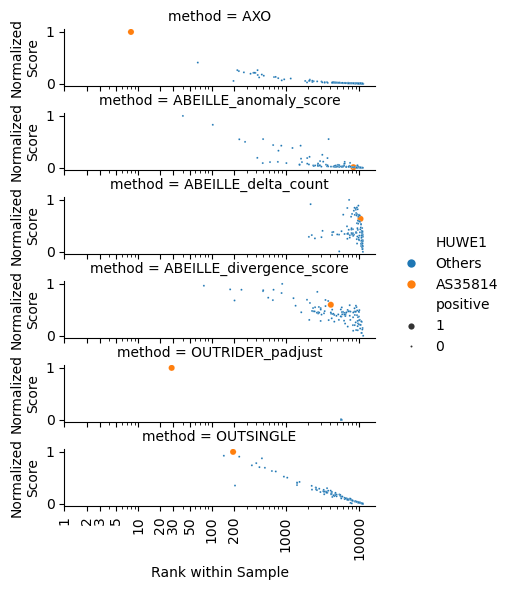

In [91]:
m = 'OUTRIDER_padjust'
# dict_rank
# dict_score[m]
# res_data.
# df_pred_ord = (res_data
#         .rename(columns={gene_col:'Gene', sample_col: 'Sample',})
#        .set_index(['Gene','Sample']))
# df_pred_ord = pd.DataFrame(df_pred_ord['padjust']).unstack(level='Sample').droplevel(level=0, axis=1)
# df_pred_ord


key1,key2 = 'Normalized\nScore','Rank within Sample'

for g_i,s_i in zip(show_g,show_s):
    if g_i not in [ 'HUWE1',]:
        continue
    print(g_i, s_i)
    dotname = g_i

    test = pd.concat( [ pd.concat([dict_score[k].loc[g_i,:].T, dict_rank[k].loc[g_i,:].T],
                                  axis=1,keys=[key1,key2]) 
                       for k in draw_methods ],
                     axis=0, keys=dict_rank)
    test[dotname] = 'Others'
    test['positive'] = 0
    if type(s_i) is list:
        for s in s_i:
            test.loc[(slice(None),s),dotname ] = s
    else:
        test.loc[(slice(None),s_i),dotname ] = s_i
        
    test.loc[(slice(None),s_i),'positive'] = 1

    test.index.names = ['method','sample']

    g = sns.relplot( data = test.rename(index={'f0.1L20':'AXO'}), row='method',
        x=key2, y=key1, hue=dotname,
                size='positive', size_order=[1,0],sizes=(2,20), #hue='model', hue_order=show,style='linestyle', style_order= list_style,
        kind="scatter", alpha=1, palette='tab10',height=1, aspect=4)
    sns.despine(left=False, bottom=False)
    plt.xscale('log')
    ranks_ticks = [1,2,3,5,10,20,30,50,100,200, 1000,10000]
    plt.xticks(ranks_ticks,ranks_ticks,rotation=90)
    
    g.tight_layout(w_pad=0, h_pad=0.1)
    # plt.ylabel(None) 
    # filename = '/media/eys/xwj/expression_outlier/output/fig_known_eout_rank_pk_baselinemodels_scatter.%s_%s.svg' % ("ly111", g_i)
    if False:
        plt.savefig(f'{workdir}/result/figure/ly111_rank_by_gene{g_i}_{'_'.join(s_i)}.pdf',dpi=200,bbox_inches='tight' )

In [94]:
test.loc[(slice(None),'AS35814'),:]

,,Normalized\nScore,Rank within Sample,HUWE1,positive
method,sample,,,,
f0.1L20,AS35814,1.000000,8.0,AS35814,1
ABEILLE_anomaly_score,AS35814,0.011320,8310.5,AS35814,1
ABEILLE_delta_count,AS35814,0.635265,10362.0,AS35814,1
ABEILLE_divergence_score,AS35814,0.597996,4102.0,AS35814,1
OUTRIDER_padjust,AS35814,1.000000,28.5,AS35814,1
OUTSINGLE,AS35814,1.000000,194.0,AS35814,1


In [28]:
show_s = ['AS35814',
          ['AS23162262','AS23162263'],
          'AS30696',
          'AS23161440','AS60159',
          ['AS39082','AS40521','AS40688'],
          ['AS30833','AS73212',],
          'AS81707','AS79750','AS75367','AS74365',
         ['AS60481','AS60480']
]
show_g = ['HUWE1', 
          'BBS2',
          'EXT2',
          'BTK','WWOX',
          'TMEM147',
          'BRAT1',
          'MED25','TSC2','STRADA','GLE1',
          'UBA5',
]

i=3
g_i = show_g[i]
s_i = show_s[i]

for g_i,s_i in zip(show_g,show_s):
    print(g_i, s_i)

HUWE1 AS35814
BBS2 ['AS23162262', 'AS23162263']
EXT2 AS30696
BTK AS23161440
WWOX AS60159
TMEM147 ['AS39082', 'AS40521', 'AS40688']
BRAT1 ['AS30833', 'AS73212']
MED25 AS81707
TSC2 AS79750
STRADA AS75367
GLE1 AS74365
UBA5 ['AS60481', 'AS60480']


'AS60481_AS60480'